In [1]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [3]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


# Scale the Dataset

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
fault_free = DF[DF['faultNumber']==0].iloc[:,3:]

fault_free_scaled = sc.fit_transform(fault_free)

# K-means algorithm

In [70]:
from sklearn.cluster import KMeans

# Define the number of clusters
k = 1

# Fit k-means clustering model
kmeans = KMeans(n_clusters=k).fit(fault_free_scaled)

In [71]:
kmeans.cluster_centers_

array([[-1.75620699e-15,  3.25417084e-14,  3.21792903e-15,
        -4.46797621e-15,  6.33886166e-16, -2.60803041e-14,
         7.66324693e-15, -2.24881689e-14, -1.68152669e-12,
        -3.59690944e-16,  1.50902217e-14,  7.63575247e-15,
         4.56855789e-14, -5.33369970e-15, -2.38581599e-15,
         1.05189886e-13, -1.88082083e-15,  7.07399637e-14,
        -1.55278124e-15,  2.04901616e-14, -6.68118316e-14,
        -4.16047716e-14, -1.25825816e-15,  2.13367990e-15,
         6.89196078e-15, -1.10502898e-14,  7.24308880e-15,
         4.47478410e-15, -1.56073270e-14, -2.60016881e-14,
         4.10588630e-15,  5.46776846e-16, -8.20800850e-15,
         1.82875155e-14,  3.13214477e-15,  2.13474671e-15,
        -5.37444755e-16, -5.17762544e-15,  1.73835968e-15,
         1.29355646e-14,  1.93755386e-14, -5.52040147e-15,
        -2.28373631e-15, -7.59051433e-16, -4.03344200e-15,
         8.24206570e-15, -6.33767083e-15, -3.83510823e-15,
         1.60649716e-15, -9.59022639e-16,  6.82927595e-1

# Visualize the Distance of Fault free data from centre

In [73]:
from sklearn.metrics import pairwise_distances

def distanceFromCenter(cluster_center,X):
    p_dist=[]
    for i in range(len(X)):
        dist= pairwise_distances(cluster_center, X[i].reshape(1, -1))
        p_dist.append(dist)
    return np.array(p_dist).reshape(-1)

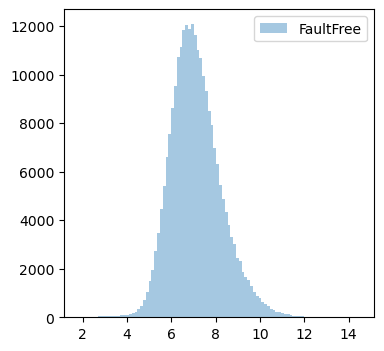

In [75]:
df = DF[DF['faultNumber']==0].iloc[:,3:]
df_sc = sc.transform(df)

FaultFree_dist=distanceFromCenter(cluster_center=kmeans.cluster_centers_,X=df_sc)

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(FaultFree_dist, bins=100,label='FaultFree',alpha=0.4)
plt.legend()
plt.show()

# Realtime Fault detection

In [77]:
# Obtain mean and standard deviation for 
mu = np.mean(FaultFree_dist)
std = np.std(FaultFree_dist)

# Obtain threshold from mu and std
threshold = mu+2*std
threshold

9.423630900039466

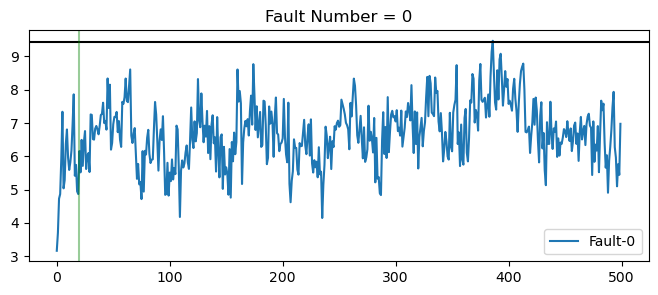

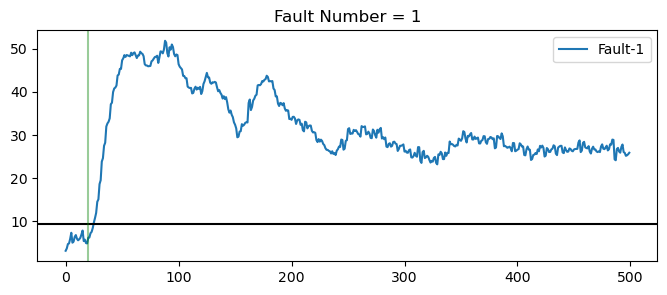

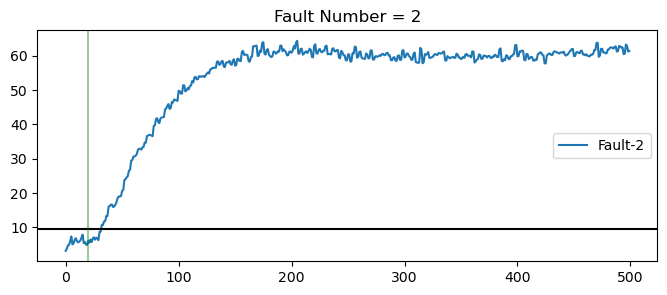

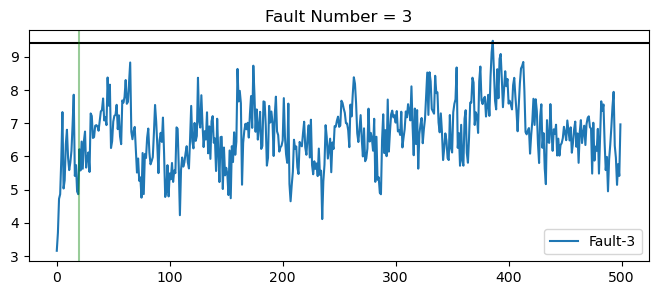

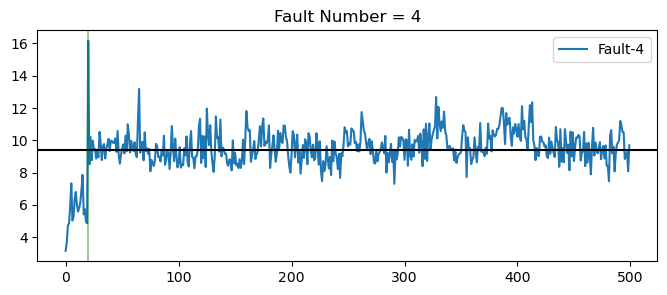

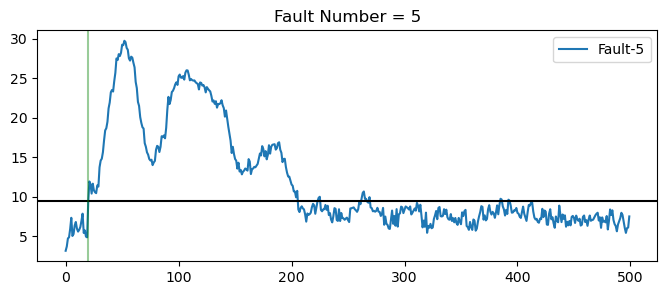

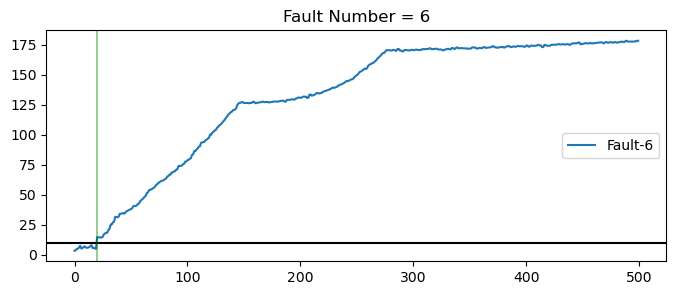

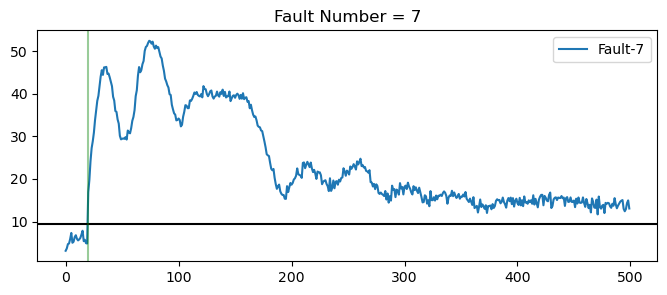

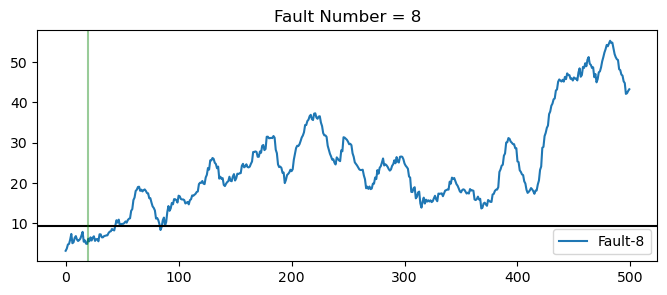

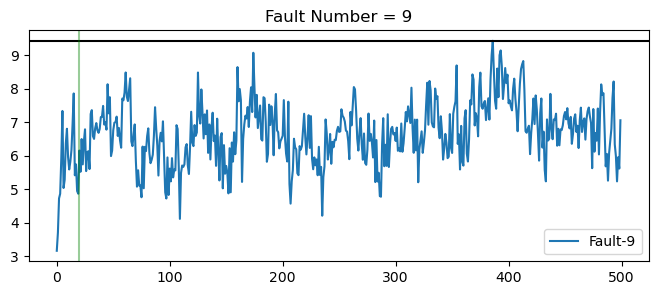

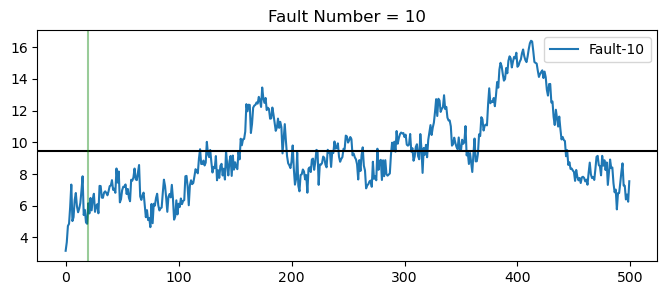

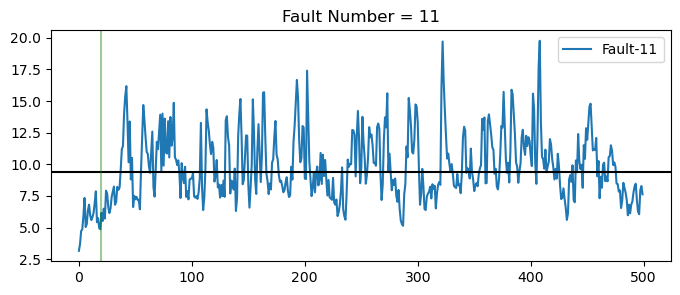

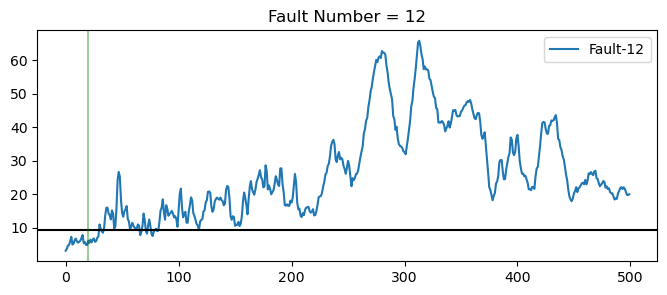

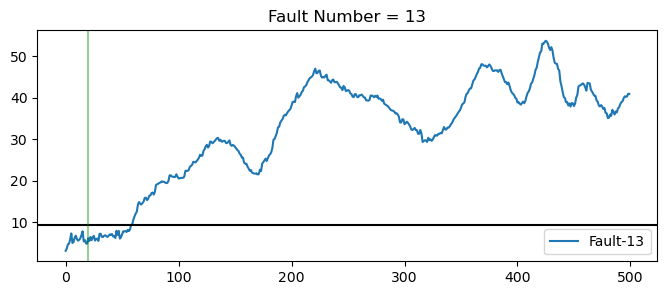

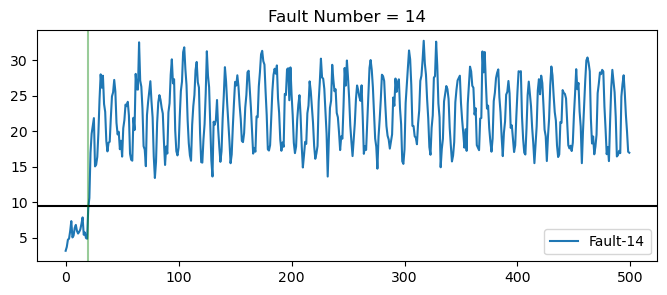

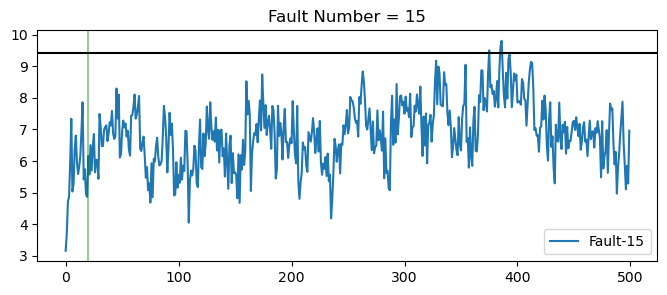

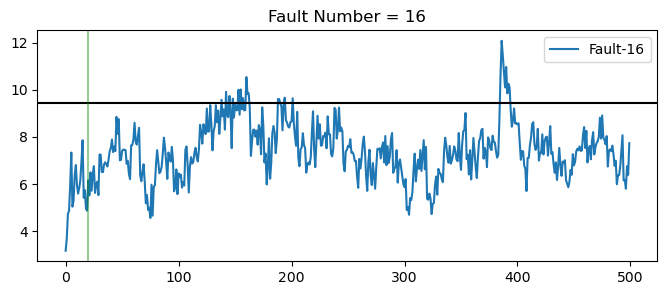

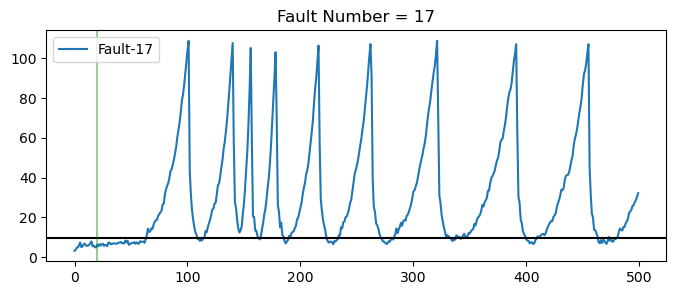

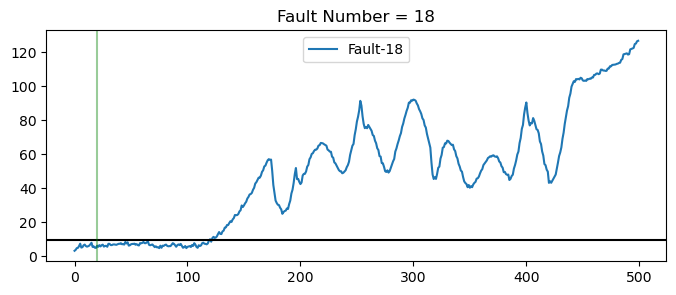

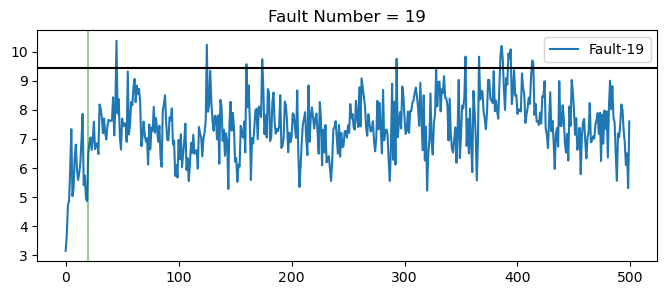

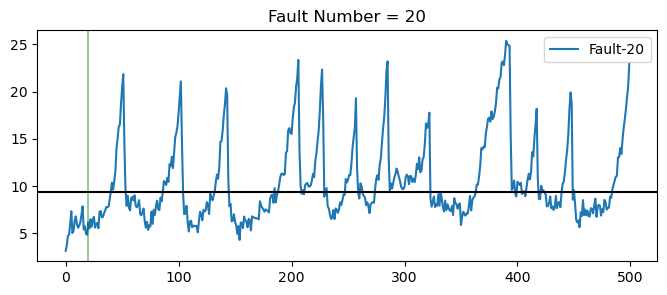

In [78]:

for F_num in range(0,21):
    # store the required fault class and simulation run
    temp = DF[(DF.faultNumber==F_num) & (DF.simulationRun==1 )]  #Faulty Condition
    # Standardization
    X_faulty = sc.transform(temp.iloc[:,3:])
    # Obtain distnace from the cluster's center
    faulty_dist = distanceFromCenter(cluster_center=kmeans.cluster_centers_,X=X_faulty)

    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(faulty_dist ,label=f'Fault-{F_num}')
    plt.axhline(threshold,c='k')    #threshold value
    plt.axvline(20,c='g',alpha=0.4) #time of fault introduction
    plt.title(f'Fault Number = {F_num}')
    plt.legend()
    plt.show()

    

# Evaluate F1 score to compare performance

In [79]:
def combine_result(x,threshold):
    # IF reconstruction loss is grater than threshold THEN its a fault
    result= x > threshold
    result_float = [float(val) for val in result] 
    return result_float

In [80]:
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,500)) ]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    
    # Obtain distnace from the cluster's center
    faulty_dist = distanceFromCenter(cluster_center=kmeans.cluster_centers_,X=X_faulty)

    #populate the true value (y_true) based of Fnum
    y_pred = combine_result(x=faulty_dist,threshold=threshold)
    
    
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample
        

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f'The F1-Score for Fault_num={Fnum} is {f1}')
    print(f'The Accuracy-Score for Fault_num={Fnum} is {acc}')
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

The F1-Score for Fault_num=0 is 0.4994994994994995
The Accuracy-Score for Fault_num=0 is 0.998
[[499   1]
 [  0   0]]
The F1-Score for Fault_num=1 is 0.9650959860383944
The Accuracy-Score for Fault_num=1 is 0.994
[[ 21   0]
 [  3 476]]
The F1-Score for Fault_num=2 is 0.8904186009443924
The Accuracy-Score for Fault_num=2 is 0.978
[[ 21   0]
 [ 11 468]]
The F1-Score for Fault_num=4 is 0.5152499737972959
The Accuracy-Score for Fault_num=4 is 0.704
[[ 20   1]
 [147 332]]
The F1-Score for Fault_num=5 is 0.4364811022747115
The Accuracy-Score for Fault_num=5 is 0.574
[[ 20   1]
 [212 267]]
The F1-Score for Fault_num=6 is 0.9872835016149952
The Accuracy-Score for Fault_num=6 is 0.998
[[ 20   1]
 [  0 479]]
The F1-Score for Fault_num=7 is 0.9872835016149952
The Accuracy-Score for Fault_num=7 is 0.998
[[ 20   1]
 [  0 479]]
The F1-Score for Fault_num=8 is 0.8107774578362814
The Accuracy-Score for Fault_num=8 is 0.954
[[ 21   0]
 [ 23 456]]
The F1-Score for Fault_num=10 is 0.38207594073611095
The

# Get the mean-F1 score of all types of faults from (0-21) for bench marking

In [81]:
F1_all = [] #initialize the emplty list of F1 score
Acc_all = []
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])
    
    # Obtain distnace from the cluster's center
    faulty_dist = distanceFromCenter(cluster_center=kmeans.cluster_centers_,X=X_faulty)

    
    y_pred = combine_result(x=faulty_dist,threshold=threshold)
    
    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample

    # Obtain F1 score    
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    F1_all.append(f1)
    Acc_all.append(acc)
    
print(f'The mean F1-Score for K-means method is {np.mean(np.array(F1_all))}')
print(f'The mean Accuracy-Score for K-means method is {np.mean(np.array(Acc_all))}')

The mean F1-Score for K-means method is 0.6120682376480931
The mean Accuracy-Score for K-means method is 0.7173684210526317
